In [1]:
#!pip install emoji
import pandas as pd
import numpy as np
import emoji
import regex
import random
import nltk
import re
import sklearn
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples 
np.random.seed(10)
random.seed(10)
seed = 10

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
df = pd.read_csv('data2021.csv')
print(len(df))
df = df.drop_duplicates(subset=['user_id']) # remove duplicates

392446


In [4]:
df.dropna(subset=['user_description'], inplace=True) # remove NaN values

In [5]:
df['user_description']

1         Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸...
2         IT ICT IoT || •AgriFoodTech •Biobased •Circula...
6         Leesbaar, kroniek van gebeurtenissen in Amsterdam
7         Mijn #TOTELTUIN ++ #Noseflutejob ++ Bach on th...
8         Columnist https://t.co/eX0BHLeWH2. Boosdrietig...
                                ...                        
392401    Je suis un 🤖 veillant sur la qualité de l'air ...
392414    Voor het meest uitgebreide zakelijke nieuws be...
392416    Uitgeverij Historische Verhalen publiceert kor...
392422    Dutch,Jewish,single,had a great friend for lif...
392442     Gitarist (klassiek) 🎸🎼🎵🎶 en 🖥️🗃️🛠️ 😎 IT-Goeroe 😎
Name: user_description, Length: 92363, dtype: object

In [6]:
def give_emoji_free_text(text):
    """
    Description:
        Removes emojis from given text (biographies)
    Input:
        Text as string (biographies)
    Output:
        Text as string (emoji free biographies)
    Example:
        >>> give_emoji_free_text('Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸')
        'Wiskunde lover, honden freak.'
    """
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Description:
        Removes URLs from given text (biographies)
    Input:
        Text as string (biographies)
    Output:
        Text as string (URL free biographies)
    Example:
        >>> url_free_text('Columnist https://t.co/eX0BHLeWH2. Boosdrietig')
        'Columnist Boosdrietig'
    '''
    text = re.sub(r'http\S+', '', text)
    return text

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Apply the give_emoji_free_text function and get biographies free of emojis
call_emoji_free = lambda x: give_emoji_free_text(x)

wordnet_lemmatizer = WordNetLemmatizer()
def preprocessing(bio):
    '''
    Description:
        Preprocesses input text by: removing: punctuation, emojis, URLs, Dutch and English stopwords, \
        tokenisation, lowercasing and lemmatisation.
    Input:
        Text as string (biographies)
    Output:
        Text as list (preprocessed biographies)
    Example:
        >>> preprocessing('Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸')
        [wiskunde, lover, honden, freak]
    '''
    
    bio = "".join([i for i in bio if i not in (string.punctuation + '•')]) # Remove punctuation
    bio = call_emoji_free(bio) # Remove emojis
    bio = url_free_text(bio).rstrip() # Remove URLs
    bio = word_tokenize(bio, language="dutch") # Tokenise the biography
    
    bio = [item.lower() for item in bio] # lowercase
    
    stopwords = nltk.corpus.stopwords.words('dutch')
    bio = [i for i in bio if i not in stopwords] # Remove Dutch stopwords
    
    stopwords = nltk.corpus.stopwords.words('english')
    bio = [i for i in bio if i not in stopwords] # Remove English stopwords
    
    bio = [wordnet_lemmatizer.lemmatize(word) for word in bio] # Lemmatise the biographies
    
    return bio
    

In [8]:
df['preprocessed'] = df['user_description'].apply(preprocessing)

# Remove biographies which contain links only
df = df[df.astype(str)['preprocessed'] != '[]']

In [9]:
df['preprocessed']

1                          [wiskunde, lover, honden, freak]
2         [ict, iot, agrifoodtech, biobased, circular, d...
6            [leesbaar, kroniek, gebeurtenissen, amsterdam]
7         [toteltuin, noseflutejob, bach, sheepdogwhistl...
8         [columnist, boosdrietig, vanwege, tweet, jamme...
                                ...                        
392401    [suis, un, veillant, sur, la, qualité, lair, q...
392414    [meest, uitgebreide, zakelijke, nieuws, bezoek...
392416    [uitgeverij, historische, verhalen, publiceert...
392422    [dutchjewishsinglehad, great, friend, life, po...
392442                       [gitarist, klassiek, itgoeroe]
Name: preprocessed, Length: 90898, dtype: object

In [10]:

sentences_list =  df['preprocessed'].values
sentences = []
for i in sentences_list:
    detok = " ".join(i)
    sentences.append(detok)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sentences)



In [11]:

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

def elbow(min=10,max=25):
    ''' 
    Description:
        Computes a graphical visualisation of the Elbow Method given a min and max value for K
    Args:
        min: Minimal value of K
        max: Maximum value of K
    Output:
        A graphical visualisation of the Elbow Method
    '''
    Sum_of_squared_distances =[]
    K = range(min,max)
    for k in K:
        km =KMeans(n_clusters =k, n_init = 10, random_state=seed) # Initialise the k-means clusterer
        km =km.fit(X) # Compute k-means clustering
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.show()

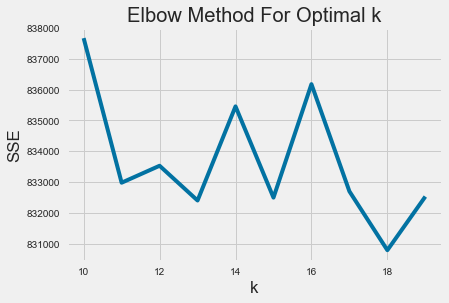

In [12]:
elbow(10, 20)

In [13]:
# adopted from: https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
def mbkmeans_clusters(
    X, 
    k, 
    mb, 
    print_silhouette_values, 
    n_init = 10,
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb, random_state=seed).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_



clustering, cluster_labels = mbkmeans_clusters(
    X=X,
    k=50,
    mb=500,
    print_silhouette_values=True,
)

C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 50
Silhouette coefficient: -0.12
Inertia:844975.4584667764
Silhouette values:
    Cluster 13: Size:2 | Avg:0.54 | Min:0.54 | Max: 0.55
    Cluster 0: Size:7 | Avg:0.13 | Min:0.09 | Max: 0.18
    Cluster 39: Size:12 | Avg:0.09 | Min:0.06 | Max: 0.14
    Cluster 33: Size:3 | Avg:0.06 | Min:-0.02 | Max: 0.13
    Cluster 6: Size:360 | Avg:0.01 | Min:-0.06 | Max: 0.07
    Cluster 1: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 2: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 4: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 7: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 8: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 9: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 10: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 11: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 14: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 15: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 16: Size:1 | Avg:0.00 | Min:0.00 | Max: 0

In [14]:
km = KMeans(n_clusters = 13, n_init = 10, random_state=seed) # Initialise the k-means clusterer
km = km.fit(X) # Compute k-means clustering

In [15]:
label = km.predict(X) # Compute cluster centers and predict cluster index for each sample

In [16]:
centers = (km.cluster_centers_)

In [17]:
cluster_dict = {}
freq_dict = {}
for count, value in enumerate(sentences):
    if label[count] in cluster_dict:
        freq_dict[label[count]] += 1
        cluster_dict[label[count]] += value
    else:
        freq_dict[label[count]] = 1
        cluster_dict[label[count]] = value

In [18]:
from collections import Counter
cluster = {}
name_list = []

for i in cluster_dict:
    wordsList = str(cluster_dict[i]).split()
    wordsList = [ x for x in wordsList if x.isalpha() ]
    counters = Counter(wordsList)
    most_occur = counters.most_common(10)
    n_words = []
    for word in most_occur:
        n_words.append(word[0])
        
    name_list.append(n_words[0])
    print(n_words, "Cluster:", i, "Size:", freq_dict[i])
    cluster[i] = n_words[0]

['nieuws', 'vader', 'nederland', 'politiek', 'fan', 'jaar', 'life', 'moeder', 'sport', 'muziek'] Cluster: 6 Size: 79266
['tweet', 'persoonlijke', 'titel', 'eigen', 'twittert', 'dutch', 'personal', 'english', 'titeltweet', 'som'] Cluster: 11 Size: 3914
['account', 'twitter', 'fan', 'nieuws', 'volg', 'tweet', 'medium', 'officiële', 'nederland', 'personal'] Cluster: 1 Size: 1303
['dag', 'elke', 'nieuws', 'per', 'uur', 'iedere', 'gelachen', 'nieuwe', 'wij', 'geleefd'] Cluster: 10 Size: 590
['love', 'music', 'life', 'nature', 'animal', 'people', 'fan', 'world', 'live', 'food'] Cluster: 5 Size: 1893
['leven', 'geniet', 'laten', 'mensen', 'moeder', 'dingen', 'wereld', 'graag', 'leef', 'muziek'] Cluster: 7 Size: 1466
['free', 'speech', 'feel', 'life', 'freedom', 'palestine', 'thinker', 'world', 'spirit', 'right'] Cluster: 3 Size: 406
['natuur', 'muziek', 'fotografie', 'cultuur', 'dieren', 'wandelen', 'milieu', 'politiek', 'landschap', 'sport'] Cluster: 2 Size: 1087
['gemeente', 'twitteraccount

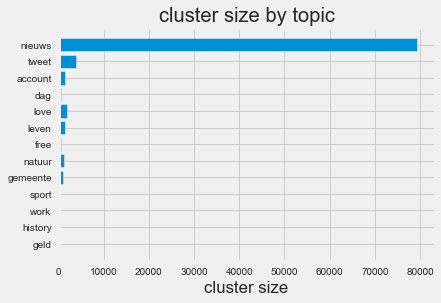

In [19]:
cluster_number = list(freq_dict.keys())
cluster_size = list(freq_dict.values())

fig, ax = plt.subplots()

ax.barh(np.arange(len(name_list)), cluster_size, align='center')
ax.set_yticks(np.arange(len(name_list)), labels=name_list)
ax.invert_yaxis()
ax.set_xlabel('cluster size')
ax.set_title('cluster size by topic')

plt.show()